# probabilistic programming (in `numpyro`) 

In [1]:
from functools import reduce, partial
product = partial(reduce, lambda x,y: x * y)

import jax.numpy as jnp
from jax import random, vmap, grad

import arviz as az
from matplotlib import pyplot as plt
from ipywidgets.widgets import FloatSlider
from ipywidgets import interact
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde, zscore

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value, NUTS, MCMC
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal, AutoDiagonalNormal

import pandas as pd

from clean import Clean

key = random.PRNGKey(0)

In [2]:
clean = Clean("data/10-22-2021-sample-data.csv", abso=False)
df = clean.df
df.head()

,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
0,2.067659,2.243548e+11,1.475697e+11,8.032713e+10,6.558503e+10,2.924764e+11,1.373189e+34,-6.812162e+10,4.640556e+21
1,1.073261,2.626122e+11,4.022874e+09,2.176361e+09,3.527153e+10,3.586240e+10,-6.780080e+32,2.267498e+11,5.141547e+22
2,2.259081,7.061592e+10,1.231400e+11,1.013308e+10,1.199092e+09,9.825665e+10,7.098000e+31,-2.764073e+10,7.640097e+20
3,2.207330,1.894204e+11,4.743854e+10,1.564121e+11,1.838070e+11,3.841779e+11,8.617764e+34,-1.947575e+11,3.793050e+22
4,1.776335,4.577537e+11,1.195981e+10,1.628059e+11,2.445517e+11,3.899494e+11,-4.993929e+33,6.780430e+10,4.597423e+21


In [17]:
product = partial(reduce, lambda x,y: x * y)
def _invariant(A: float, D: float, *balances: list) -> float:
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        D ** (n + 1) 
        + 
        (A - n ** (- n)) * n_raised_2n * product(balances) * D 
        + 
        (- A * n_raised_2n * product(balances) * sum(balances))
    )

def _invariant_dmnlynormd_1(A: float, D: float, *balances: list) -> float: 
    """invariant divided by product of balances"""
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        product(D / b for b in balances) * D
        +
        (A - n ** (- n)) * n_raised_2n * D
        + 
        (- A * n_raised_2n * sum(balances))
    )

def _DD_invariant_dmnlynormd_1(A: float, D: float, *balances: list) -> float: 
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        (n + 1) * product(D / b for b in balances) 
        +
        (A - 1 / n ** n) * n_raised_2n
    )

def _invariant_dmnlynormd_2(A: float, D: float, *balances: list) -> float: 
    """invariant divided by product of balances divided by D"""
    n = len(balances)
    n_raised_2n = n ** (2 * n)
    return (
        product(D / b for b in balances)
        +
        (A - 1 / n ** n) * n_raised_2n
        + 
        (- A * n_raised_2n * sum(balances) / D)
    )

def balances(idx: int) -> tuple:
    return df.B0[idx], df.B1[idx], df.B2[idx]
 
def invariant(idx: int) -> float:
    return _invariant(df.A[idx], df.D[idx], df.B0[idx], df.B1[idx], df.B2[idx])

def geometric_mean_balances(idx: int) -> float: 
    return product((df.B0[idx], df.B1[idx], df.B2[idx])) ** (1 / 3)

# invariant(2) / geometric_mean_balances(2), invariant(2) / df.D[2] ** (3), invariant(2) / product((df.B0[2], df.B1[2], df.B2[2])), invariant(2) / (sum((df.B0[2], df.B1[2], df.B2[2])) / 3) ** 3
invariant(2) / product(balances(2)), _invariant_dmnlynormd_1(df.A[2], df.D[2], *balances(2))

(-90450082237714.83, -90450082237714.83)

In [4]:
A = 85 # egorov 2019 # dat.A.mean()
n = 3
A * n ** (2 * n), (A - 1 / n ** n) * n ** (2 * n)

(61965, 61938.0)

In [206]:
def inv_model__dimnlynormd_by_prodbalances(D, root=None):
    """Get the posterior distribution of roots.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", """
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.Exponential(1e-2))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1e-12)) for i in range(LEN_BALANCES)]
    
    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
    numpyro.sample("root", dist.Normal(3e10, 1e10), obs=root)

In [207]:
def inv_model__dimnlynormd_by_D_tothe_n(D, root=None):
    """Get the posterior distribution of roots.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", """
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.Exponential(1e-2))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1e-12)) for i in range(LEN_BALANCES)]
    
    I = numpyro.deterministic("I", _invariant(A, D, *balances) / D ** LEN_BALANCES)
    numpyro.sample("root", dist.Normal(3e10, 1e10), obs=root)

In [208]:
quap_invmodel__dimnlynormd_by_prodbalances = AutoLaplaceApproximation(inv_model__dimnlynormd_by_prodbalances)
svi__dimnlynormd_by_prodbalances = SVI(
    inv_model__dimnlynormd_by_prodbalances,
    quap_invmodel__dimnlynormd_by_prodbalances,
    optim.Adam(1),
    Trace_ELBO(),
    D=df.D.values,
    root=df.Root.values,
)
svi_dimnlynormd_by_prodbalances_result = svi__dimnlynormd_by_prodbalances.run(random.PRNGKey(0), 2000)
params__dimnlynormd_by_prodbalances = svi_dimnlynormd_by_prodbalances_result.params

100%|█████████████| 2000/2000 [00:01<00:00, 1393.12it/s, init loss: 5667906.5000, avg. loss [1901-2000]: 5667817.0000]


In [187]:
samples = quap_invmodel__dimnlynormd_by_prodbalances.sample_posterior(random.PRNGKey(1), params__dimnlynormd_by_prodbalances, (1000,))
# samples.pop("mu")
print_summary(samples, 0.89, False)

/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:213: RuntimeWarning: invalid value encountered in subtract
  intervals_length = intervals_right - intervals_left
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:119: RuntimeWarning: invalid value encountered in subtract
  centered_signal = x - x.mean(axis=-1, keepdims=True)
/opt/conda/lib/python3.9/site-packages/numpyro/diagnostics.py:173: RuntimeWarning: invalid value encountered in subtract
  rho_k = 1.0 - (var_within - gamma_k_c.mean(


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         A    162.44    219.18     93.61      7.24    321.00   1004.62      1.00
        B0 1740798951424.00 2243851976704.00 1033277472768.00 59765587968.00 3619152986112.00    719.48      1.00
        B1 1697524350976.00 2265734709248.00 1011911753728.00 43412729856.00 3386844381184.00    833.95      1.00
        B2 1545337700352.00 1740034277376.00 1023869255680.00 56858206208.00 3154394218496.00    959.77      1.00
      I[0]       inf       nan       inf       inf       inf       nan       nan
      I[1]       inf       nan       inf       inf       inf       nan       nan
      I[2]       inf       nan       inf       inf       inf       nan       nan
      I[3]       inf       nan       inf       inf       inf       nan       nan
      I[4]       inf       nan       inf       inf       inf       nan       nan
      I[5]       inf       nan       inf       inf       inf       nan       nan
      I[6

In [370]:
def model(D, inv_D=None): # inv_model__dimnlynormd_by_prodbalances__targeting_y(D, Y=None):
    """Get the posterior distribution of Y values.
    
    With invariant dimensionally normalized to "$" rather than "$ ^ (n + 1)", by dividing it by product of balances"""
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.LogNormal(4.1, 0.5))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1)) for i in range(LEN_BALANCES)]
    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
    sigma = numpyro.sample("sigma", dist.Uniform(0, I.std()))

    numpyro.sample("inv_D", dist.Normal(I, sigma), obs=inv_D)

df_z = (df - df.mean()) / df.std()
    
quap = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    quap,
    optim.Adam(1),
    Trace_ELBO(),
    D=df_z.D.values,
    inv_D=df_z.Y.values,
)
svi_result = svi.run(random.PRNGKey(0), 2000)
params_svi_result = svi_result.params

samples = quap.sample_posterior(random.PRNGKey(1), params_svi_result, (1000,))
samples.pop("I")
print_summary(samples, 0.89, False)

100%|█████████████████| 2000/2000 [00:04<00:00, 424.16it/s, init loss: 362023.2812, avg. loss [1901-2000]: 44920.7695]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         A      0.01      0.00      0.01      0.01      0.01   1006.20      1.00
        B0      0.87      0.03      0.87      0.81      0.92    740.90      1.00
        B1      0.87      0.03      0.87      0.81      0.91   1001.62      1.00
        B2      0.87      0.03      0.87      0.81      0.91   1036.68      1.00
     sigma      0.48      0.00      0.48      0.48      0.49    862.72      1.00



In [ ]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 6)

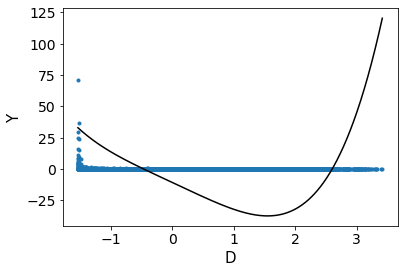

In [372]:
az.plot_pair(df_z[["D", "Y"]].to_dict(orient="list"));
post = quap.sample_posterior(random.PRNGKey(1), params_svi_result, (1000,))
A_map = post["A"].mean()
B0_map = post["B0"].mean()
B1_map = post["B1"].mean()
B2_map = post["B2"].mean()
x = jnp.linspace(df_z.D.min(), df_z.D.max(), 1001)
plt.plot(x, _invariant_dmnlynormd_1(A_map, x, B0_map, B1_map, B2_map), "k");

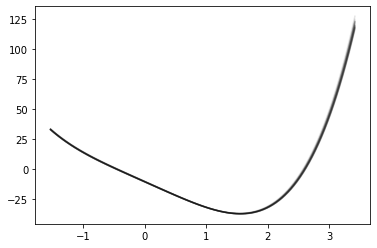

In [378]:
# extract 20 samples from the posterior
post = quap.sample_posterior(key, params_svi_result, (20,))

# display raw data and sample size
# ax = az.plot_pair(df_z[["D", "Y"]].to_dict(orient="list"))
ax.set(
    xlim=(df_z.D.min(), df_z.D.max()),
    # ylim=(df_z.Y.min(), df_z.Y.max()),
)

# plot the lines, with transparency
x = jnp.linspace(df_z.D.min(), df_z.D.max(), 101)
for i in range(20):
    plt.plot(x, _invariant_dmnlynormd_1(post["A"][i], x, post["B0"][i], post["B1"][i], post["B2"][i]), "k", alpha=0.1)


# MCMC

In [427]:
# Now we're going to use MCMC to train on Y with Root as input, instead of D.
def model(root, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A = numpyro.sample("A", dist.LogNormal(4.1, 0.5))
    balances = [numpyro.sample(f"B{i}", dist.Exponential(1)) for i in range(LEN_BALANCES)]
    with numpyro.plate("I", root.shape[0]): 
        I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, root, *balances))
        sigma = numpyro.sample("sigma", dist.Uniform(0, I.std()))
    numpyro.sample("Y", dist.Normal(I, sigma), obs=Y)

In [428]:
nuts_kernel = NUTS(model)

df_z_1000 = df_z.sample(int(1e3))
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, df_z_1000.Root.values, Y=df_z_1000.Y.values)

posterior_samples = mcmc.get_samples()

sample: 100%|█████████████████████████| 4000/4000 [00:59<00:00, 66.73it/s, 127 steps of size 2.72e-02. acc. prob=0.83]


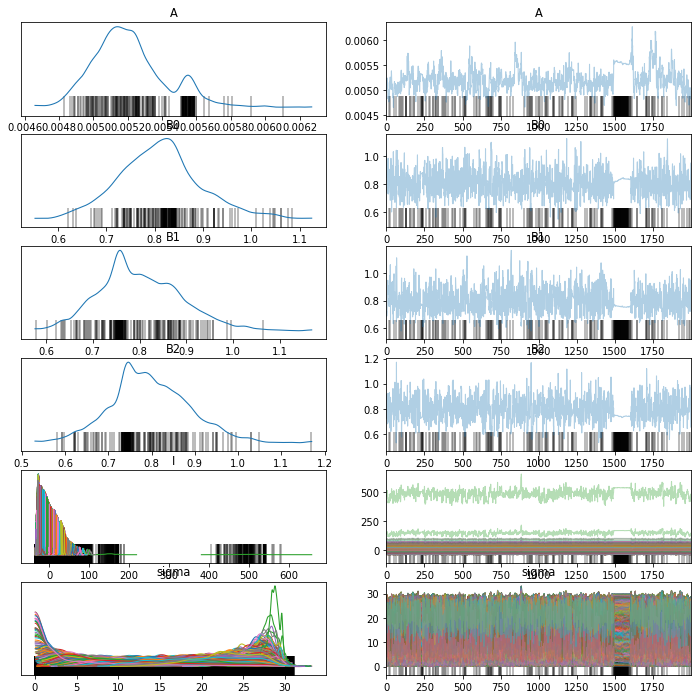

In [429]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [431]:
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

# New idea lmao: simpler model, that supposes `A` and `balances` are fixed, that _learns_ root by targeting the invariant model to zero. 

In [435]:
df.head()

,A,D,B0,B1,B2,Root,Y,newton_delta,squared_newton_delta
0,2.067659,2.243548e+11,1.475697e+11,8.032713e+10,6.558503e+10,2.924764e+11,1.373189e+34,-6.812162e+10,4.640556e+21
1,1.073261,2.626122e+11,4.022874e+09,2.176361e+09,3.527153e+10,3.586240e+10,-6.780080e+32,2.267498e+11,5.141547e+22
2,2.259081,7.061592e+10,1.231400e+11,1.013308e+10,1.199092e+09,9.825665e+10,7.098000e+31,-2.764073e+10,7.640097e+20
3,2.207330,1.894204e+11,4.743854e+10,1.564121e+11,1.838070e+11,3.841779e+11,8.617764e+34,-1.947575e+11,3.793050e+22
4,1.776335,4.577537e+11,1.195981e+10,1.628059e+11,2.445517e+11,3.899494e+11,-4.993929e+33,6.780430e+10,4.597423e+21


In [467]:
dat = ((df - df.mean()) / df.std()).sample(frac=0.4)
product = partial(reduce, lambda x,y: x * y)

def model(D, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A = numpyro.deterministic("A", dat.A.mean())
    balances = [numpyro.deterministic(f"B{k}", dat[f"B{k}"].mean()) for k in range(LEN_BALANCES)]
    numpyro.sample("sigma", dist.Uniform(0, product(balances)))
    with numpyro.plate("I", D.shape[0]): 
        I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
        
        numpyro.sample("Y", dist.Normal(I, 1), obs=Y)

nuts_kernel = NUTS(model)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_rootfinding.run(rng_key, dat.D.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
# posterior_samples

sample: 100%|███████████████████████| 4000/4000 [00:08<00:00, 458.32it/s, 1023 steps of size 2.32e-05. acc. prob=1.00]


/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your d

KeyboardInterrupt: 

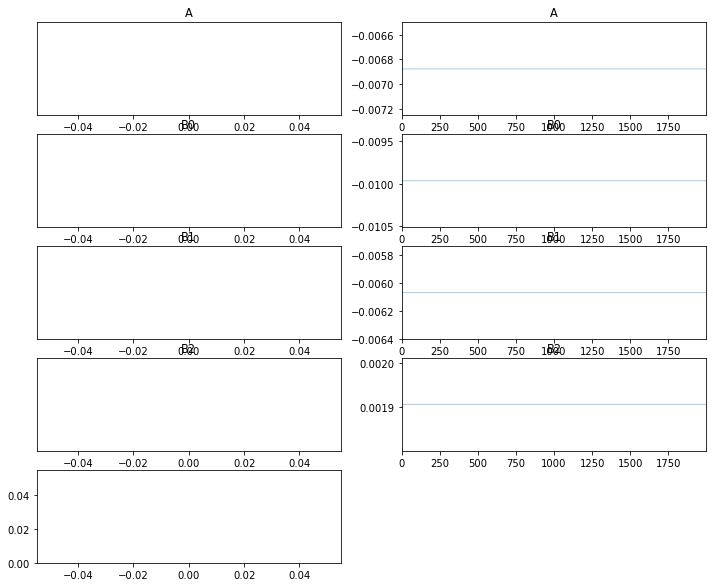

In [466]:
# doesn't seem to want to work. maybe model too simple for mcmc
data_rootfinding = az.from_numpyro(mcmc_rootfinding)
az.plot_trace(data_rootfinding, compact=True);

In [ ]:
dat = (df - df.mean()) / df.std()
product = partial(reduce, lambda x,y: x * y)

def model(D, Y=None): 
    """Training to hit zero"""
    LEN_BALANCES = 3
    A = numpyro.deterministic("A", dat.A.mean())
    balances = [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]

    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
        
    numpyro.sample("Y", dist.Normal(I, 1), obs=Y)

quap = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    quap,
    optim.Adam(1),
    Trace_ELBO(),
    D=dat.D.values,
    Y=jnp.zeros(dat.shape[0]),
)
svi_result = svi.run(key, 2000)

samples = quap.sample_posterior(key, svi_result.params, (1000,))
print_summary({key: value for key,value in samples.items() if key != "I"}, 0.89, False)

100%|████████| 2000/2000 [00:04<00:00, 465.54it/s, init loss: 3207804747776.0000, avg. loss [1901-2000]: 3833878.5000]


In [205]:
dat = df # (df - df.mean()) / df.std()
product = partial(reduce, lambda x,y: x * y)

def model_constant_product(b0, b1, b2, Y=None): 
    """Training to hit zero"""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0, b1, b2)#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]
    
    sigma = numpyro.sample("sigma", dist.Normal(1e1, 1e-1))
    D = numpyro.sample("D", dist.LogNormal(LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES), sigma))

    # D = numpyro.sample("D", dist.LogNormal(1, 0.1))
    I = numpyro.deterministic("I", _invariant_dmnlynormd_2(A, jnp.exp(D), *balances))
    log_epsilon = numpyro.sample("log_epsilon", dist.Uniform(1e-16, 10))
    numpyro.sample("Y", dist.Normal(I, jnp.exp(log_epsilon)), obs=Y)

quap = AutoLaplaceApproximation(model_constant_product)
an = AutoDiagonalNormal(model_constant_product)
svi = SVI(
    model_constant_product,
    an,
    optim.Adam(1),
    Trace_ELBO(),
    b0=dat.B0.values,
    b1=dat.B1.values,
    b2=dat.B2.values,
    Y=jnp.zeros(dat.shape[0]),
)
svi_result = svi.run(key, 2000)

samples = an.sample_posterior(key, svi_result.params, (1000,))
# samples["D_summary"] = samples["D"].mean()
print_summary({key: value for key,value in samples.items() if key != "I" and key != "D"}, 0.89, False)

100%|█| 2000/2000 [00:05<00:00, 333.76it/s, init loss: 8551882291059515815635896953208832.0000, avg. loss [1901-2000]:



                   mean       std    median      5.5%     94.5%     n_eff     r_hat
  log_epsilon      2.11      0.18      2.11      1.83      2.38    997.95      1.00
        sigma      0.22      0.10      0.22      0.05      0.38    901.96      1.00



In [241]:
balances = [dat[f"B{k}"].mean() for k in range(3)]
# _invariant_dmnlynormd_2(dat.A.mean(), sum(balances), *balances)

# 3 * product(balances) ** (1 / 3), jnp.array(balances).std()
samples["D"].mean(), _invariant_dmnlynormd_2(85, samples["D"], *balances).mean(), hpdi(samples["D"], prob=0.9).mean(axis=1)


(DeviceArray(1.8388689, dtype=float32),
 DeviceArray(-3.8639055e+16, dtype=float32),
 array([1.5391227, 2.1338344], dtype=float32))

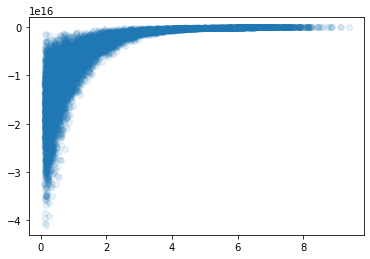

In [233]:
# az.plot_kde(samples["I"]);
plt.scatter(samples["D"][0], samples["I"][0], alpha=0.1);

In [112]:
dat = df # / df.std()
product = partial(reduce, lambda x,y: x * y)

def model_constant_sum(Y=None): 
    """Training to hit zero"""
    LEN_BALANCES = 3
    A = 85 # egorov 2019 # dat.A.mean()
    balances = [dat[f"B{k}"].mean() for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]
    
    D = numpyro.sample("D", dist.Normal(sum(balances), LEN_BALANCES)) # jnp.array(balances).std()))
    
    # D = numpyro.sample("D", dist.LogNormal(1, 0.1))
    I = numpyro.deterministic("I", _invariant_dmnlynormd_2(A, D, *balances))
    log_epsilon = numpyro.sample("epsilon", dist.Uniform(1e-16, 2))
    # print(I)
    numpyro.sample("Y", dist.Normal(I, jnp.exp(log_epsilon)), obs=Y)

quap = AutoLaplaceApproximation(model_constant_sum)
svi = SVI(
    model_constant_sum,
    quap,
    optim.Adam(1),
    Trace_ELBO(),
    # D=dat.D.values,
    Y=jnp.zeros(dat.shape[0]),
)
svi_result = svi.run(key, 2000)

samples = quap.sample_posterior(key, svi_result.params, (1000,))
print_summary({key: value for key,value in samples.items() if key != "I"}, 0.89, False)

100%|█| 2000/2000 [00:01<00:00, 1225.92it/s, init loss: 1496817901844413969457353894634979328.0000, avg. loss [1901-20



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         D      0.22      0.00      0.22      0.22      0.22      0.50       nan
   epsilon      1.71      0.00      1.71      1.71      1.71      0.50      1.00



In [259]:
balances = [dat[f"B{k}"].mean() for k in range(3)]
# _invariant_dmnlynormd_2(dat.A.mean(), sum(balances), *balances)

# 3 * product(balances) ** (1 / 3), jnp.array(balances).std()
samples["D"].mean(), _invariant_dmnlynormd_2(85, samples["D"], *balances).mean(), samples["I"].mean()


(DeviceArray(1.8388689, dtype=float32),
 DeviceArray(-3.891663e+16, dtype=float32),
 DeviceArray(-8.223864e+15, dtype=float32))

In [ ]:
@interact(D=FloatSlider(min=0, max=dat.D.min()))
def model_kde(D: float):
    az.plot_kde(_invariant_dmnlynormd_1(samples["A"], D, samples["B0"], samples["B1"], samples["B2"]), label=f"I({D}) < epsilon")


In [ ]:
samples["I"].mean()

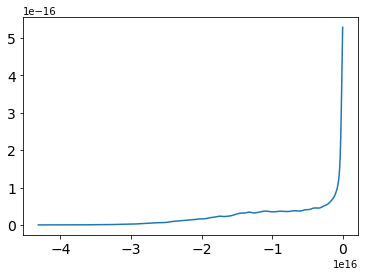

In [212]:
az.plot_kde(samples["I"]);

In [247]:
dat = df.sample(frac=0.4) # ((df - df.mean()) / df.std()).sample(frac=0.4)
product = partial(reduce, lambda x,y: x * y)

def model_constant_product(b0, b1, b2, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0, b1, b2)#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]
    
    sigma = numpyro.sample("sigma", dist.Normal(1e1, 1e-1))
    D = numpyro.sample("D", dist.LogNormal(LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES), sigma))

    # D = numpyro.sample("D", dist.LogNormal(1, 0.1))
    with numpyro.plate("obs", b0.shape[0]): 
        I = numpyro.deterministic("I", _invariant_dmnlynormd_2(A, jnp.exp(D), *balances))
    log_epsilon = numpyro.sample("log_epsilon", dist.Uniform(1e-16, 10))
    numpyro.sample("Y", dist.Normal(I, jnp.exp(log_epsilon)), obs=Y)

nuts_kernel = NUTS(model_constant_product)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_rootfinding.run(rng_key, b0=dat.B0.values, b1=dat.B1.values, b2=dat.B2.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
# posterior_samples

sample: 100%|███████████████████████████| 4000/4000 [00:40<00:00, 97.60it/s, 1 steps of size 9.97e-02. acc. prob=0.24]


In [ ]:
print_summary({key: value for key,value in posterior_samples.items() if key != "I" and key != "D"}, 0.89, False)

In [258]:
balances = [dat[f"B{k}"].mean() for k in range(3)]

posterior_samples["D"].mean(), _invariant_dmnlynormd_2(85, posterior_samples["D"], *balances).mean(), 


(DeviceArray(26.65538, dtype=float32),
 DeviceArray(-8.026891e+14, dtype=float32),
 DeviceArray(-8.223864e+15, dtype=float32))

KeyboardInterrupt: 

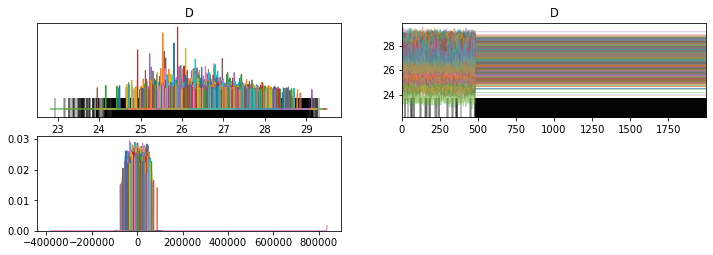

In [ ]:
data_rootfinding = az.from_numpyro(mcmc_rootfinding)
az.plot_trace(data_rootfinding, compact=True);

# THIS IS THE WINNER APPARENTLY: (caveat: not with `frac=1`, only with `frac=0.1` which is extremely unfortunate)

In [185]:
dat = (df / df.std()).sample(frac=0.1) # ((df - df.mean()) / df.std()).sample(frac=0.4)

def model_constant_product(b0, b1, b2, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0, b1, b2)#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]

    sigma_Y = numpyro.sample("sigma_Y", dist.HalfNormal(1e0))
    
    with numpyro.plate("getD", b0.shape[0]): 
        D = numpyro.sample("D", dist.HalfNormal(LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES)))
        I = numpyro.deterministic("I", _invariant_dmnlynormd_2(A, D, *balances))
        numpyro.sample("Y", dist.Normal(I, sigma_Y), obs=Y)

nuts_kernel = NUTS(model_constant_product)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)

mcmc_rootfinding.run(rng_key, b0=dat.B0.values, b1=dat.B1.values, b2=dat.B2.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
# posterior_samples

sample: 100%|█████████████████████████| 4000/4000 [00:19<00:00, 207.74it/s, 15 steps of size 9.14e-03. acc. prob=0.84]


In [186]:
posterior_samples["I"].mean(), posterior_samples["I"].std(), posterior_samples["D"].mean() # , posterior_samples["I"].min()

(DeviceArray(-0.00110871, dtype=float32),
 DeviceArray(4.603236, dtype=float32),
 DeviceArray(4.438125, dtype=float32))

In [198]:
hpdi(posterior_samples["I"], axis=1)

array([[-7.066089 ,  7.703929 ],
       [-7.549384 ,  7.059693 ],
       [-7.48186  ,  7.1849256],
       ...,
       [-6.666361 ,  7.5947037],
       [-7.151231 ,  7.633746 ],
       [-7.1039147,  7.9216337]], dtype=float32)

In [199]:
print_summary({key: value for key,value in posterior_samples.items() if key != "I" and key != "D"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
   sigma_Y      4.60      0.07      4.61      4.49      4.72      7.64      1.05



In [200]:
data_rootfinding = az.from_numpyro(mcmc_rootfinding)
data_rootfinding

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
import io
with io.open("out.png", "w") as file:
    az.plot_trace(data_rootfinding, compact=False).tofile(file)

In [197]:
pred = Predictive(model_constant_product, posterior_samples)
pred(key, dat.B0.values, dat.B1.values, dat.B2.values)["I"]
dir(pred)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_shape',
 'batch_ndims',
 'guide',
 'infer_discrete',
 'model',
 'num_samples',
 'parallel',
 'params',
 'posterior_samples',
 'return_sites']

# messing around with causality: distance between product or sum of balances and D as a parameter

In [170]:
dat = (df / df.std()).sample(frac=0.1) # ((df - df.mean()) / df.std()).sample(frac=0.4)

def model_constant_product(b0, b1, b2, Y=None): 
    """Constant product D, but validated against minimizing it's distance to constant sum D."""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0, b1, b2)#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]
    Dlhs_product = LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES)
    with numpyro.plate("getD", b0.shape[0]): 
        D = numpyro.sample("D", dist.HalfNormal(Dlhs_product))
        I = numpyro.deterministic("I", _invariant_dmnlynormd_2(A, D, *balances))
    
    epsilon = numpyro.sample("epsilon", dist.HalfNormal(jnp.abs(D - sum(balances))))
    sigma_Y = numpyro.sample("sigma_Y", dist.HalfNormal(epsilon))
    numpyro.sample("Y", dist.Normal(I, sigma_Y), obs=Y)

nuts_kernel = NUTS(model_constant_product)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)

mcmc_rootfinding.run(rng_key, b0=dat.B0.values, b1=dat.B1.values, b2=dat.B2.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
posterior_samples["I"].mean(), posterior_samples["D"].mean()

sample: 100%|██████████████████████████| 4000/4000 [00:24<00:00, 161.25it/s, 5 steps of size 4.72e-07. acc. prob=0.81]


(DeviceArray(-83404.54, dtype=float32), DeviceArray(2.999052, dtype=float32))

In [171]:
data_rootfinding = az.from_numpyro(mcmc_rootfinding)
# az.plot_trace(data_rootfinding, compact=True);
data_rootfinding

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:978: RuntimeWarning: divide by zero encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:978: RuntimeWarning: invalid value encountered in true_divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:696: RuntimeWarning: divide by zero encountered in true_divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:696: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
/opt/conda/lib/python3.9/site-packages/arviz/stats/density_utils.py:699: RuntimeWarning: divide by zero encountered in double_scalars
  bw /= bin_width


OverflowError: cannot convert float infinity to integer

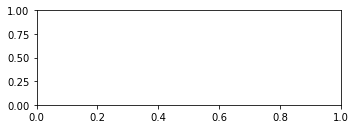

In [172]:
az.plot_trace(data_rootfinding, compact=True);

# lmao newton inside the model

In [ ]:
dat = df.sample(frac=0.1) # ((df - df.mean()) / df.std()).sample(frac=0.4)
# product = partial(reduce, lambda x,y: x * y)

def model_constant_product_internalnewton(b0, b1, b2, Y=None): 
    """A model for MCMC"""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0, b1, b2)#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]

    sigma_D = numpyro.sample("sigma_D", dist.HalfNormal(1e1, 1e3))
    sigma_Y = numpyro.sample("sigma_Y", dist.HalfNormal(1e1, 1e3))
    
    with numpyro.plate("getD", b0.shape[0]): 
        D = numpyro.sample("D", dist.HalfNormal(LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES), 1e3))
        for i in range(64):
            D -= _invariant_dmnlynormd_1(A, D, *balances) / _DD_invariatn_dmnlynormd_1(A, D, *balances)
        Dprime = numpyro.deterministic("Dprime", D)
        I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, Dprime, *balances))
        numpyro.sample("Y", dist.Normal(I, sigma_Y), obs=Y)

nuts_kernel = NUTS(model_constant_product_internalnewton)

# print(dat.D.values.shape, dat.shape[0])
mcmc_rootfinding = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc_rootfinding.run(rng_key, b0=dat.B0.values, b1=dat.B1.values, b2=dat.B2.values, Y=jnp.zeros(dat.shape[0]))

posterior_samples = mcmc_rootfinding.get_samples()
# posterior_samples

  0%|                                                                                        | 0/4000 [00:00<?, ?it/s]

In [ ]:
print_summary({key: value for key,value in posterior_samples.items() if key != "I" and key != "D"}, 0.89, False)

In [ ]:
posterior_samples["I"].mean(), posterior_samples["D"].mean(), posterior_samples["Dprime"].mean()

In [59]:
dat = df / df.std() # ((df - df.mean()) / df.std())

def model_constant_product_internalnewton(b0, b1, b2, Y=None): 
    """A model where newton is ran internally"""
    LEN_BALANCES = 3
    A =  85 # egorov 2019 #  numpyro.deterministic("A", dat.A.mean())
    balances = (b0.mean(), b1.mean(), b2.mean())#[dat[f"B{k}"].mean()for k in range(LEN_BALANCES)]# [numpyro.sample(f"B{k}", dist.Normal(D / LEN_BALANCES)) for k in range(LEN_BALANCES)]

    sigma_Y = numpyro.sample("sigma_Y", dist.HalfNormal(1e2))
    
    D = numpyro.sample("D", dist.HalfNormal(LEN_BALANCES * product(balances) ** (1 / LEN_BALANCES)))

    for i in range(4):
        D -= _invariant_dmnlynormd_1(A, D, *balances) / _DD_invariant_dmnlynormd_1(A, D, *balances)
    I = numpyro.deterministic("I", _invariant_dmnlynormd_1(A, D, *balances))
    numpyro.sample("Y", dist.Normal(I, sigma_Y), obs=Y)

quap = AutoLaplaceApproximation(model_constant_product_internalnewton)
an = AutoDiagonalNormal(model_constant_product_internalnewton)
svi = SVI(
    model_constant_product_internalnewton,
    an,
    optim.Adam(1),
    Trace_ELBO(),
    b0=dat.B0.values,
    b1=dat.B1.values,
    b2=dat.B2.values,
    Y=jnp.zeros(dat.shape[0]),
)
svi_result = svi.run(key, 2000)

samples = an.sample_posterior(key, svi_result.params, (1000,))
# samples["D_summary"] = samples["D"].mean()
print_summary({key: value for key,value in samples.items() if key != "I" and key != "D" and key != "Dprime"}, 0.89, False)

100%|█████████████████████████| 2000/2000 [00:02<00:00, 794.26it/s, init loss: 12014.2803, avg. loss [1901-2000]: nan]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
   sigma_Y       nan       nan       nan       nan       nan       nan       nan



In [60]:
samples["I"].mean()

DeviceArray(nan, dtype=float32)

In [61]:
pred = Predictive(model_constant_product_internalnewton, samples)
pred(key, dat.B0.values, dat.B1.values, dat.B2.values)["I"]

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan

In [62]:
D = dat.Root.mean()
for i in range(1024):
    numer = _invariant_dmnlynormd_1(85, D, *(dat.B0.values.mean(), dat.B1.values.mean(), dat.B2.values.mean()))
    denom = _DD_invariant_dmnlynormd_1(85, D, *(dat.B0.values.mean(), dat.B1.values.mean(), dat.B2.values.mean()))
    if jnp.isnan(numer): 
        raise ValueError("numer is nan")
    if jnp.isnan(denom): 
        raise ValueError("denom is nan")
    D -= numer / denom
D

4.589664474628134

In [77]:
341128183426984605819627467795901 / 50000000000000000000

6822563668539.692

# Playing with autodiff

In [348]:
grad_inv = grad(_invariant_dmnlynormd_1)
grad_inv(A_map, df.D.mean(), B0_map, B1_map, B2_map)

DeviceArray(1.6804887e+14, dtype=float32)

In [351]:
grad_inv(A_map, df.D.mean(), B0_map, B1_map, B2_map)

DeviceArray(1.6804887e+14, dtype=float32)

In [366]:
# the gradient of the scalar field
jnp.stack(list(map(lambda f: f(A_map, df_z.D.mean(), B0_map, B1_map, B2_map), [grad(_invariant_dmnlynormd_1, argnums=i) for i in range(4)])))


DeviceArray([-1900.375  ,   -22.97826,    -4.02174,    -4.02174], dtype=float32)

# Getting eyes on basic distributions

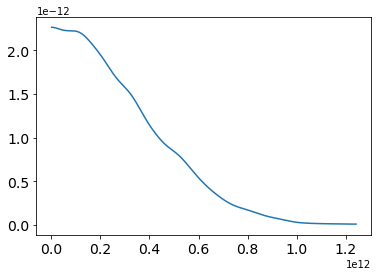

In [51]:
num_samples = 10000
distribution = dist.Normal(3e10, 1e10)
distribution2 = dist.Normal(4e10, 2e10)
exponential = dist.Exponential(5e-2)
lognormal = dist.LogNormal(1, 0.1)
weight = 0.01
poisson = dist.Poisson(7)
halfcauchy = dist.HalfCauchy(1)
halfnormal = dist.HalfNormal(1e1, 1e3)
exp_log = dist.Exponential(jnp.log(89.60632577589753))
balances = [df[f"B{k}"].mean() for k in range(3)]
test = dist.Exponential((3 * product(balances) ** (1 / 3) / sum(balances)))
uniform = dist.Uniform(0, 10)
test2 = dist.HalfNormal(3 * product(balances) ** (1 / 3), 1e3)

# sample = weight * distribution.sample(random.PRNGKey(0), (num_samples,)) + (1 - weight) * distribution2.sample(random.PRNGKey(0), (num_samples,))
sample = weight * uniform.sample(key, (num_samples,)) + (1 - weight) * halfnormal.sample(key, (num_samples,))
sample = test2.sample(key, (num_samples,)) 

az.plot_kde(sample);

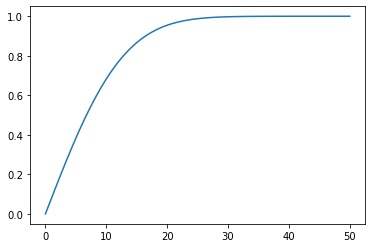

In [45]:
plt.plot(
    jnp.linspace(start=0, stop=50, num=101),
    halfnormal.cdf(x)
);

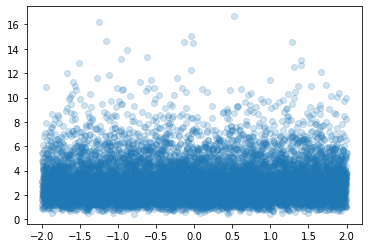

In [7]:
plt.scatter(
    jnp.linspace(start=-2, stop=2, num=num_samples),
    sample,
    alpha=0.2
);

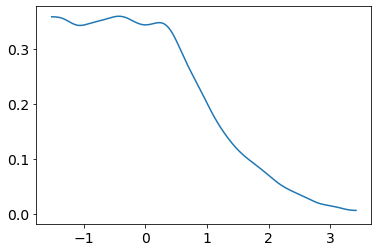

In [383]:
az.plot_kde(df_z.B1);

<AxesSubplot:>

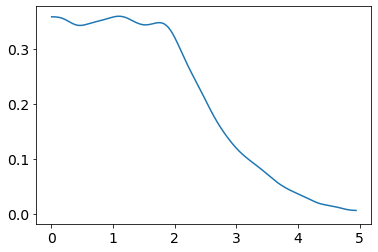

In [151]:
az.plot_kde(df.B1 / df.B1.std())# .sample(frac=1));

In [85]:
df.B1.sample(frac=0.1)

9289    8.898805e+10
1978    1.161146e+11
6189    1.508713e+11
5010    2.560199e+11
3765    1.898380e+11
            ...     
7202    6.078768e+10
9368    1.805757e+11
6652    3.996354e+10
7791    1.415550e+11
5679    4.307347e+09
Name: B1, Length: 1000, dtype: float64